## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import tensorflow.keras as keras
import tensorflow as tf
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.7)  
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from tensorflow.keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.2, 0.5, 0.8]
redice_lr_patient = [5, 10, 15]



In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=reduce_patient, 
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.20, reduce_patient: 5
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
bat

49/49 [==============================] - 0s 9ms/step - loss: 1.3092 - accuracy: 0.5451 - val_loss: 1.5024 - val_accuracy: 0.4786 - lr: 0.0010
Epoch 11/25
49/49 [==============================] - 0s 9ms/step - loss: 1.2811 - accuracy: 0.5559 - val_loss: 1.4941 - val_accuracy: 0.4805 - lr: 0.0010
Epoch 12/25
49/49 [==============================] - 0s 10ms/step - loss: 1.2554 - accuracy: 0.5660 - val_loss: 1.4945 - val_accuracy: 0.4795 - lr: 0.0010
Epoch 13/25
49/49 [==============================] - 0s 10ms/step - loss: 1.2284 - accuracy: 0.5759 - val_loss: 1.4905 - val_accuracy: 0.4788 - lr: 0.0010
Epoch 14/25
49/49 [==============================] - 0s 9ms/step - loss: 1.2031 - accuracy: 0.5852 - val_loss: 1.4796 - val_accuracy: 0.4855 - lr: 0.0010
Epoch 15/25
49/49 [==============================] - 0s 9ms/step - loss: 1.1773 - accuracy: 0.5944 - val_loss: 1.4778 - val_accuracy: 0.4895 - lr: 0.0010
Epoch 16/25
49/49 [==============================] - 0s 10ms/step - loss: 1.1536 - acc

Epoch 1/25
49/49 [==============================] - 1s 12ms/step - loss: 2.2337 - accuracy: 0.2615 - val_loss: 2.1425 - val_accuracy: 0.1896 - lr: 0.0010
Epoch 2/25
49/49 [==============================] - 0s 9ms/step - loss: 1.7388 - accuracy: 0.3915 - val_loss: 1.9791 - val_accuracy: 0.2721 - lr: 0.0010
Epoch 3/25
49/49 [==============================] - 0s 9ms/step - loss: 1.6141 - accuracy: 0.4333 - val_loss: 1.8220 - val_accuracy: 0.3618 - lr: 0.0010
Epoch 4/25
49/49 [==============================] - 0s 10ms/step - loss: 1.5420 - accuracy: 0.4608 - val_loss: 1.7167 - val_accuracy: 0.4020 - lr: 0.0010
Epoch 5/25
49/49 [==============================] - 0s 9ms/step - loss: 1.4888 - accuracy: 0.4783 - val_loss: 1.6379 - val_accuracy: 0.4259 - lr: 0.0010
Epoch 6/25
49/49 [==============================] - 0s 9ms/step - loss: 1.4414 - accuracy: 0.4957 - val_loss: 1.5880 - val_accuracy: 0.4379 - lr: 0.0010
Epoch 7/25
49/49 [==============================] - 0s 10ms/step - loss: 1.4042 

49/49 [==============================] - 1s 10ms/step - loss: 1.2677 - accuracy: 0.5618 - val_loss: 1.5134 - val_accuracy: 0.4692 - lr: 5.0000e-04
Epoch 19/25
49/49 [==============================] - 0s 10ms/step - loss: 1.2525 - accuracy: 0.5665 - val_loss: 1.5033 - val_accuracy: 0.4747 - lr: 5.0000e-04
Epoch 20/25
49/49 [==============================] - 1s 10ms/step - loss: 1.2367 - accuracy: 0.5739 - val_loss: 1.4975 - val_accuracy: 0.4744 - lr: 5.0000e-04
Epoch 21/25
49/49 [==============================] - 0s 10ms/step - loss: 1.2201 - accuracy: 0.5812 - val_loss: 1.5041 - val_accuracy: 0.4718 - lr: 5.0000e-04
Epoch 22/25
49/49 [==============================] - 0s 10ms/step - loss: 1.2057 - accuracy: 0.5845 - val_loss: 1.4970 - val_accuracy: 0.4734 - lr: 5.0000e-04
Epoch 23/25
49/49 [==============================] - 1s 10ms/step - loss: 1.1900 - accuracy: 0.5916 - val_loss: 1.4895 - val_accuracy: 0.4758 - lr: 5.0000e-04
Epoch 24/25
49/49 [==============================] - 0s 10

Epoch 1/25
49/49 [==============================] - 1s 12ms/step - loss: 2.3490 - accuracy: 0.2395 - val_loss: 2.1459 - val_accuracy: 0.2107 - lr: 5.0000e-04
Epoch 2/25
49/49 [==============================] - 0s 9ms/step - loss: 1.8681 - accuracy: 0.3537 - val_loss: 2.0155 - val_accuracy: 0.2854 - lr: 5.0000e-04
Epoch 3/25
49/49 [==============================] - 0s 10ms/step - loss: 1.7327 - accuracy: 0.3957 - val_loss: 1.9044 - val_accuracy: 0.3425 - lr: 5.0000e-04
Epoch 4/25
49/49 [==============================] - 0s 9ms/step - loss: 1.6530 - accuracy: 0.4235 - val_loss: 1.7962 - val_accuracy: 0.3867 - lr: 5.0000e-04
Epoch 5/25
49/49 [==============================] - 0s 10ms/step - loss: 1.5988 - accuracy: 0.4424 - val_loss: 1.7149 - val_accuracy: 0.4069 - lr: 5.0000e-04
Epoch 6/25
49/49 [==============================] - 0s 10ms/step - loss: 1.5551 - accuracy: 0.4587 - val_loss: 1.6590 - val_accuracy: 0.4250 - lr: 5.0000e-04
Epoch 7/25
49/49 [==============================] - 0s

49/49 [==============================] - 0s 10ms/step - loss: 1.2757 - accuracy: 0.5594 - val_loss: 1.4993 - val_accuracy: 0.4749 - lr: 5.0000e-04
Epoch 19/25
49/49 [==============================] - 0s 9ms/step - loss: 1.2592 - accuracy: 0.5655 - val_loss: 1.5009 - val_accuracy: 0.4752 - lr: 5.0000e-04
Epoch 20/25
49/49 [==============================] - 0s 10ms/step - loss: 1.2441 - accuracy: 0.5703 - val_loss: 1.4987 - val_accuracy: 0.4723 - lr: 5.0000e-04
Epoch 21/25
49/49 [==============================] - 0s 10ms/step - loss: 1.2285 - accuracy: 0.5777 - val_loss: 1.4939 - val_accuracy: 0.4787 - lr: 5.0000e-04
Epoch 22/25
49/49 [==============================] - 0s 9ms/step - loss: 1.2126 - accuracy: 0.5837 - val_loss: 1.4884 - val_accuracy: 0.4805 - lr: 5.0000e-04
Epoch 23/25
49/49 [==============================] - 0s 10ms/step - loss: 1.1978 - accuracy: 0.5884 - val_loss: 1.4890 - val_accuracy: 0.4798 - lr: 5.0000e-04
Epoch 24/25
49/49 [==============================] - 0s 9ms/

49/49 [==============================] - 1s 12ms/step - loss: 1.7649 - accuracy: 0.3876 - val_loss: 2.5466 - val_accuracy: 0.2186 - lr: 0.0010
Epoch 2/25
49/49 [==============================] - 0s 10ms/step - loss: 1.4951 - accuracy: 0.4733 - val_loss: 2.1246 - val_accuracy: 0.2826 - lr: 0.0010
Epoch 3/25
49/49 [==============================] - 0s 10ms/step - loss: 1.3918 - accuracy: 0.5098 - val_loss: 1.8258 - val_accuracy: 0.3480 - lr: 0.0010
Epoch 4/25
49/49 [==============================] - 0s 10ms/step - loss: 1.3112 - accuracy: 0.5378 - val_loss: 1.7472 - val_accuracy: 0.3854 - lr: 0.0010
Epoch 5/25
49/49 [==============================] - 0s 10ms/step - loss: 1.2465 - accuracy: 0.5588 - val_loss: 1.7750 - val_accuracy: 0.3816 - lr: 0.0010
Epoch 6/25
49/49 [==============================] - 0s 10ms/step - loss: 1.1837 - accuracy: 0.5828 - val_loss: 1.8038 - val_accuracy: 0.4022 - lr: 0.0010
Epoch 7/25
49/49 [==============================] - 0s 10ms/step - loss: 1.1371 - accur

Epoch 16/25
49/49 [==============================] - 0s 10ms/step - loss: 1.4314 - accuracy: 0.5032 - val_loss: 1.6071 - val_accuracy: 0.4423 - lr: 8.0000e-06
Epoch 17/25
49/49 [==============================] - 0s 10ms/step - loss: 1.4191 - accuracy: 0.5085 - val_loss: 1.6023 - val_accuracy: 0.4480 - lr: 8.0000e-06
Epoch 18/25
49/49 [==============================] - 0s 10ms/step - loss: 1.4078 - accuracy: 0.5127 - val_loss: 1.5994 - val_accuracy: 0.4480 - lr: 8.0000e-06
Epoch 19/25
49/49 [==============================] - 0s 9ms/step - loss: 1.3963 - accuracy: 0.5166 - val_loss: 1.5915 - val_accuracy: 0.4501 - lr: 8.0000e-06
Epoch 20/25
49/49 [==============================] - 0s 9ms/step - loss: 1.3856 - accuracy: 0.5202 - val_loss: 1.5918 - val_accuracy: 0.4494 - lr: 8.0000e-06
Epoch 21/25
49/49 [==============================] - 0s 10ms/step - loss: 1.3757 - accuracy: 0.5246 - val_loss: 1.5884 - val_accuracy: 0.4546 - lr: 8.0000e-06
Epoch 22/25
49/49 [=============================

Epoch 1/25
49/49 [==============================] - 1s 16ms/step - loss: 2.2206 - accuracy: 0.2589 - val_loss: 2.1345 - val_accuracy: 0.2127 - lr: 8.0000e-06
Epoch 2/25
49/49 [==============================] - 0s 10ms/step - loss: 1.8333 - accuracy: 0.3630 - val_loss: 2.0223 - val_accuracy: 0.2580 - lr: 8.0000e-06
Epoch 3/25
49/49 [==============================] - 0s 10ms/step - loss: 1.7326 - accuracy: 0.3962 - val_loss: 1.9012 - val_accuracy: 0.3344 - lr: 8.0000e-06
Epoch 4/25
49/49 [==============================] - 0s 9ms/step - loss: 1.6735 - accuracy: 0.4179 - val_loss: 1.8007 - val_accuracy: 0.3802 - lr: 8.0000e-06
Epoch 5/25
49/49 [==============================] - 0s 10ms/step - loss: 1.6295 - accuracy: 0.4310 - val_loss: 1.7332 - val_accuracy: 0.3990 - lr: 8.0000e-06
Epoch 6/25
49/49 [==============================] - 0s 9ms/step - loss: 1.5946 - accuracy: 0.4437 - val_loss: 1.6855 - val_accuracy: 0.4123 - lr: 8.0000e-06
Epoch 7/25
49/49 [==============================] - 0s

49/49 [==============================] - 0s 10ms/step - loss: 1.3708 - accuracy: 0.5273 - val_loss: 1.5628 - val_accuracy: 0.4561 - lr: 8.0000e-06
Epoch 19/25
49/49 [==============================] - 0s 10ms/step - loss: 1.3599 - accuracy: 0.5306 - val_loss: 1.5600 - val_accuracy: 0.4578 - lr: 8.0000e-06
Epoch 20/25
49/49 [==============================] - 0s 9ms/step - loss: 1.3493 - accuracy: 0.5340 - val_loss: 1.5549 - val_accuracy: 0.4597 - lr: 8.0000e-06
Epoch 21/25
49/49 [==============================] - 0s 10ms/step - loss: 1.3402 - accuracy: 0.5389 - val_loss: 1.5529 - val_accuracy: 0.4625 - lr: 8.0000e-06
Epoch 22/25
49/49 [==============================] - 1s 10ms/step - loss: 1.3305 - accuracy: 0.5421 - val_loss: 1.5496 - val_accuracy: 0.4623 - lr: 8.0000e-06
Epoch 23/25
49/49 [==============================] - 0s 10ms/step - loss: 1.3221 - accuracy: 0.5459 - val_loss: 1.5449 - val_accuracy: 0.4634 - lr: 8.0000e-06
Epoch 24/25
49/49 [==============================] - 0s 10m

49/49 [==============================] - 1s 12ms/step - loss: 2.2006 - accuracy: 0.2739 - val_loss: 2.1226 - val_accuracy: 0.2515 - lr: 8.0000e-06
Epoch 2/25
49/49 [==============================] - 0s 9ms/step - loss: 1.8234 - accuracy: 0.3714 - val_loss: 2.0080 - val_accuracy: 0.3177 - lr: 8.0000e-06
Epoch 3/25
49/49 [==============================] - 0s 10ms/step - loss: 1.7232 - accuracy: 0.4011 - val_loss: 1.9029 - val_accuracy: 0.3514 - lr: 8.0000e-06
Epoch 4/25
49/49 [==============================] - 0s 10ms/step - loss: 1.6620 - accuracy: 0.4225 - val_loss: 1.8050 - val_accuracy: 0.3788 - lr: 8.0000e-06
Epoch 5/25
49/49 [==============================] - 0s 10ms/step - loss: 1.6197 - accuracy: 0.4368 - val_loss: 1.7466 - val_accuracy: 0.3880 - lr: 8.0000e-06
Epoch 6/25
49/49 [==============================] - 0s 9ms/step - loss: 1.5863 - accuracy: 0.4493 - val_loss: 1.6973 - val_accuracy: 0.4060 - lr: 8.0000e-06
Epoch 7/25
49/49 [==============================] - 0s 9ms/step -

49/49 [==============================] - 0s 10ms/step - loss: 1.3819 - accuracy: 0.5218 - val_loss: 1.5549 - val_accuracy: 0.4550 - lr: 8.0000e-06
Epoch 19/25
49/49 [==============================] - 0s 10ms/step - loss: 1.3723 - accuracy: 0.5256 - val_loss: 1.5533 - val_accuracy: 0.4539 - lr: 8.0000e-06
Epoch 20/25
49/49 [==============================] - 0s 10ms/step - loss: 1.3622 - accuracy: 0.5287 - val_loss: 1.5485 - val_accuracy: 0.4587 - lr: 8.0000e-06
Epoch 21/25
49/49 [==============================] - 0s 10ms/step - loss: 1.3518 - accuracy: 0.5333 - val_loss: 1.5471 - val_accuracy: 0.4597 - lr: 8.0000e-06
Epoch 22/25
49/49 [==============================] - 1s 15ms/step - loss: 1.3424 - accuracy: 0.5359 - val_loss: 1.5423 - val_accuracy: 0.4620 - lr: 8.0000e-06
Epoch 23/25
49/49 [==============================] - 0s 10ms/step - loss: 1.3324 - accuracy: 0.5409 - val_loss: 1.5370 - val_accuracy: 0.4629 - lr: 8.0000e-06
Epoch 24/25
49/49 [==============================] - 0s 10

49/49 [==============================] - 1s 13ms/step - loss: 1.8064 - accuracy: 0.3744 - val_loss: 2.2937 - val_accuracy: 0.2536 - lr: 0.0010
Epoch 2/25
49/49 [==============================] - 0s 10ms/step - loss: 1.5325 - accuracy: 0.4592 - val_loss: 2.1477 - val_accuracy: 0.2747 - lr: 0.0010
Epoch 3/25
49/49 [==============================] - 0s 10ms/step - loss: 1.4241 - accuracy: 0.4982 - val_loss: 2.1792 - val_accuracy: 0.2722 - lr: 0.0010
Epoch 4/25
49/49 [==============================] - 1s 10ms/step - loss: 1.3508 - accuracy: 0.5221 - val_loss: 2.2227 - val_accuracy: 0.2904 - lr: 0.0010
Epoch 5/25
49/49 [==============================] - 0s 10ms/step - loss: 1.2888 - accuracy: 0.5455 - val_loss: 2.0899 - val_accuracy: 0.3424 - lr: 0.0010
Epoch 6/25
49/49 [==============================] - 1s 10ms/step - loss: 1.2349 - accuracy: 0.5628 - val_loss: 2.0548 - val_accuracy: 0.3290 - lr: 0.0010
Epoch 7/25
49/49 [==============================] - 0s 10ms/step - loss: 1.1886 - accur

Epoch 17/25
49/49 [==============================] - 1s 10ms/step - loss: 1.1410 - accuracy: 0.6145 - val_loss: 1.4990 - val_accuracy: 0.4782 - lr: 4.0000e-05
Epoch 18/25
49/49 [==============================] - 0s 10ms/step - loss: 1.1195 - accuracy: 0.6208 - val_loss: 1.5029 - val_accuracy: 0.4797 - lr: 4.0000e-05
Epoch 19/25
49/49 [==============================] - 1s 10ms/step - loss: 1.1001 - accuracy: 0.6295 - val_loss: 1.4887 - val_accuracy: 0.4791 - lr: 4.0000e-05
Epoch 20/25
49/49 [==============================] - 0s 10ms/step - loss: 1.0798 - accuracy: 0.6364 - val_loss: 1.4999 - val_accuracy: 0.4816 - lr: 4.0000e-05
Epoch 21/25
49/49 [==============================] - 0s 10ms/step - loss: 1.0600 - accuracy: 0.6456 - val_loss: 1.5038 - val_accuracy: 0.4814 - lr: 4.0000e-05
Epoch 22/25
49/49 [==============================] - 1s 10ms/step - loss: 1.0417 - accuracy: 0.6515 - val_loss: 1.4863 - val_accuracy: 0.4882 - lr: 4.0000e-05
Epoch 23/25
49/49 [===========================

Epoch 1/25
49/49 [==============================] - 1s 13ms/step - loss: 2.1593 - accuracy: 0.2835 - val_loss: 2.1853 - val_accuracy: 0.1964 - lr: 4.0000e-05
Epoch 2/25
49/49 [==============================] - 0s 10ms/step - loss: 1.7939 - accuracy: 0.3810 - val_loss: 2.0112 - val_accuracy: 0.3136 - lr: 4.0000e-05
Epoch 3/25
49/49 [==============================] - 0s 10ms/step - loss: 1.6653 - accuracy: 0.4212 - val_loss: 1.8601 - val_accuracy: 0.3719 - lr: 4.0000e-05
Epoch 4/25
49/49 [==============================] - 1s 11ms/step - loss: 1.5799 - accuracy: 0.4492 - val_loss: 1.7482 - val_accuracy: 0.3954 - lr: 4.0000e-05
Epoch 5/25
49/49 [==============================] - 0s 10ms/step - loss: 1.5187 - accuracy: 0.4728 - val_loss: 1.6814 - val_accuracy: 0.4191 - lr: 4.0000e-05
Epoch 6/25
49/49 [==============================] - 0s 10ms/step - loss: 1.4687 - accuracy: 0.4889 - val_loss: 1.6353 - val_accuracy: 0.4264 - lr: 4.0000e-05
Epoch 7/25
49/49 [==============================] - 

49/49 [==============================] - 0s 10ms/step - loss: 1.3300 - accuracy: 0.5404 - val_loss: 1.5458 - val_accuracy: 0.4587 - lr: 2.0000e-05
Epoch 18/25
49/49 [==============================] - 0s 10ms/step - loss: 1.3134 - accuracy: 0.5483 - val_loss: 1.5361 - val_accuracy: 0.4619 - lr: 2.0000e-05
Epoch 19/25
49/49 [==============================] - 1s 11ms/step - loss: 1.2971 - accuracy: 0.5532 - val_loss: 1.5442 - val_accuracy: 0.4563 - lr: 2.0000e-05
Epoch 20/25
49/49 [==============================] - 0s 10ms/step - loss: 1.2812 - accuracy: 0.5598 - val_loss: 1.5298 - val_accuracy: 0.4644 - lr: 2.0000e-05
Epoch 21/25
49/49 [==============================] - 0s 10ms/step - loss: 1.2661 - accuracy: 0.5643 - val_loss: 1.5279 - val_accuracy: 0.4643 - lr: 2.0000e-05
Epoch 22/25
49/49 [==============================] - 1s 11ms/step - loss: 1.2520 - accuracy: 0.5704 - val_loss: 1.5327 - val_accuracy: 0.4637 - lr: 2.0000e-05
Epoch 23/25
49/49 [==============================] - 0s 10

Epoch 1/25
49/49 [==============================] - 1s 12ms/step - loss: 2.3670 - accuracy: 0.2351 - val_loss: 2.1869 - val_accuracy: 0.1878 - lr: 2.0000e-05
Epoch 2/25
49/49 [==============================] - 0s 10ms/step - loss: 1.9775 - accuracy: 0.3277 - val_loss: 2.0937 - val_accuracy: 0.2103 - lr: 2.0000e-05
Epoch 3/25
49/49 [==============================] - 0s 10ms/step - loss: 1.8305 - accuracy: 0.3694 - val_loss: 1.9823 - val_accuracy: 0.2752 - lr: 2.0000e-05
Epoch 4/25
49/49 [==============================] - 0s 10ms/step - loss: 1.7407 - accuracy: 0.3989 - val_loss: 1.8560 - val_accuracy: 0.3455 - lr: 2.0000e-05
Epoch 5/25
49/49 [==============================] - 0s 10ms/step - loss: 1.6753 - accuracy: 0.4194 - val_loss: 1.7878 - val_accuracy: 0.3702 - lr: 2.0000e-05
Epoch 6/25
49/49 [==============================] - 1s 10ms/step - loss: 1.6249 - accuracy: 0.4366 - val_loss: 1.6987 - val_accuracy: 0.4121 - lr: 2.0000e-05
Epoch 7/25
49/49 [==============================] - 

49/49 [==============================] - 1s 11ms/step - loss: 1.2990 - accuracy: 0.5499 - val_loss: 1.5339 - val_accuracy: 0.4650 - lr: 2.0000e-05
Epoch 19/25
49/49 [==============================] - 0s 10ms/step - loss: 1.2829 - accuracy: 0.5567 - val_loss: 1.5307 - val_accuracy: 0.4667 - lr: 2.0000e-05
Epoch 20/25
49/49 [==============================] - 0s 10ms/step - loss: 1.2667 - accuracy: 0.5613 - val_loss: 1.5260 - val_accuracy: 0.4696 - lr: 2.0000e-05
Epoch 21/25
49/49 [==============================] - 1s 10ms/step - loss: 1.2510 - accuracy: 0.5688 - val_loss: 1.5273 - val_accuracy: 0.4693 - lr: 2.0000e-05
Epoch 22/25
49/49 [==============================] - 0s 10ms/step - loss: 1.2370 - accuracy: 0.5714 - val_loss: 1.5223 - val_accuracy: 0.4659 - lr: 2.0000e-05
Epoch 23/25
49/49 [==============================] - 0s 10ms/step - loss: 1.2225 - accuracy: 0.5800 - val_loss: 1.5109 - val_accuracy: 0.4695 - lr: 2.0000e-05
Epoch 24/25
49/49 [==============================] - 1s 10

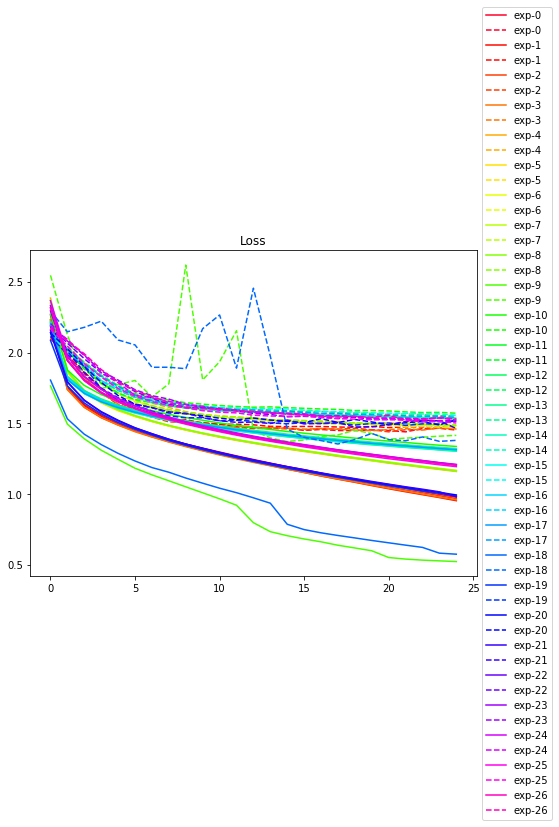

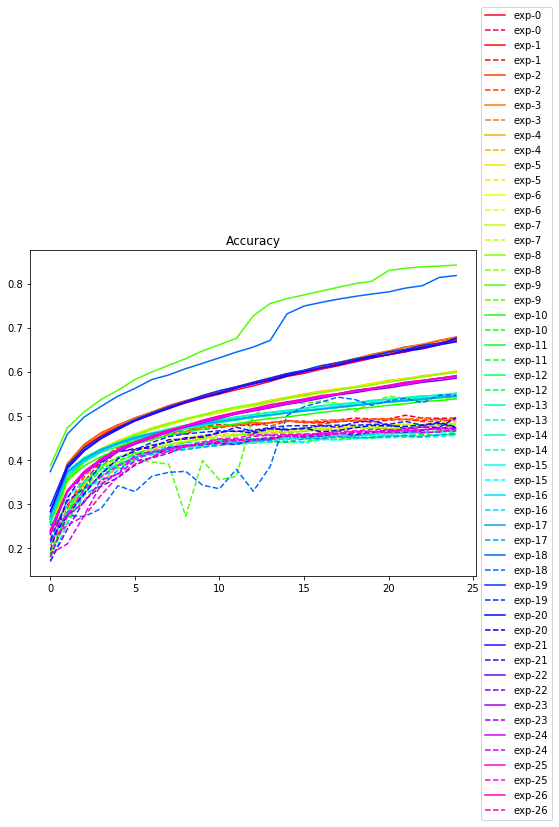

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()